In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer # fazer a transformação de colunas
from sklearn.dummy import DummyRegressor # regressor padrão para comparação
from sklearn.linear_model import Ridge, LinearRegression # modelo de regressão
from sklearn.pipeline import Pipeline # criar pipeline, etapa de processamento
from sklearn.preprocessing import (
    OrdinalEncoder, # variáveis ordinais
    OneHotEncoder, # categóricas
    PolynomialFeatures, # criar variáveis com multiplicação entre ela ou ao quadrado dela mesma 
    PowerTransformer, # transformação em potência (yeo-johnson ou box-cox)
    RobustScaler, 
    StandardScaler, # ajuste de escala das variáveis independentes
    QuantileTransformer, # normaliza os dados em quantis
)

from joblib import dump # biblioteca para salvar modelos

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [5]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [6]:
# separando todas as colunas numéricas para realizar uma transformação uniforme
# ele não é tão sensível a outliers
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [7]:
# o grau inicial da segunda etapa é 1, mas ele será alterado
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()), # primeira etapa da pipeline
    ("poly", PolynomialFeatures(degree=1, include_bias=False)), # segunda etapa da pipeline 
])

# pré-processamento pegando a pipeline com a transformação de escala e PolynomialFeatures
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler) # usando a pipeline transformada
    ],
)

In [8]:
# separando X e y da base de dados
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [9]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [10]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


Adotando os parâmetros de penalização para a regularização Ridge

In [12]:
# pegando o grau
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3], # grau poly
    "regressor__reg__alpha":[1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0], # penalização
}

Fazendo a pesquisa por grade usando o modelo Ridge

In [14]:
# criando uma pesquisa de grade buscando a melhor combinação entre 
# pré-processamento e transformação que apresenta o melhor resultado 
grid_search = grid_search_cv_regressor(
    regressor=Ridge(), # o modelo
    preprocessor=preprocessamento, # pré-processamento
    target_transformer=QuantileTransformer(output_distribution="normal"), # transformação no target
    param_grid=param_grid, # grau, penalização e regularização
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   30.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [15]:
# treinando o grid_search
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   30.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

In [17]:
# métrica RMSE (Root Mean Square Error - raiz do erro quadrático médio)
# é a métrica de desempate no refit de validação cruzada da função grid_search_cv_regressor
grid_search.best_score_

np.float64(-50450.25977089901)

In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.021467
robust_scaler_poly__latitude,-0.960667
one_hot_encoder__ocean_proximity_INLAND,-0.459333
robust_scaler_poly__latitude longitude population_per_household,-0.416997
robust_scaler_poly__population_per_household,-0.326569
...,...
robust_scaler_poly__latitude median_income population_per_household,0.245686
robust_scaler_poly__housing_median_age median_income,0.245766
robust_scaler_poly__latitude^2 longitude,0.248007
robust_scaler_poly__bedrooms_per_room,0.334976


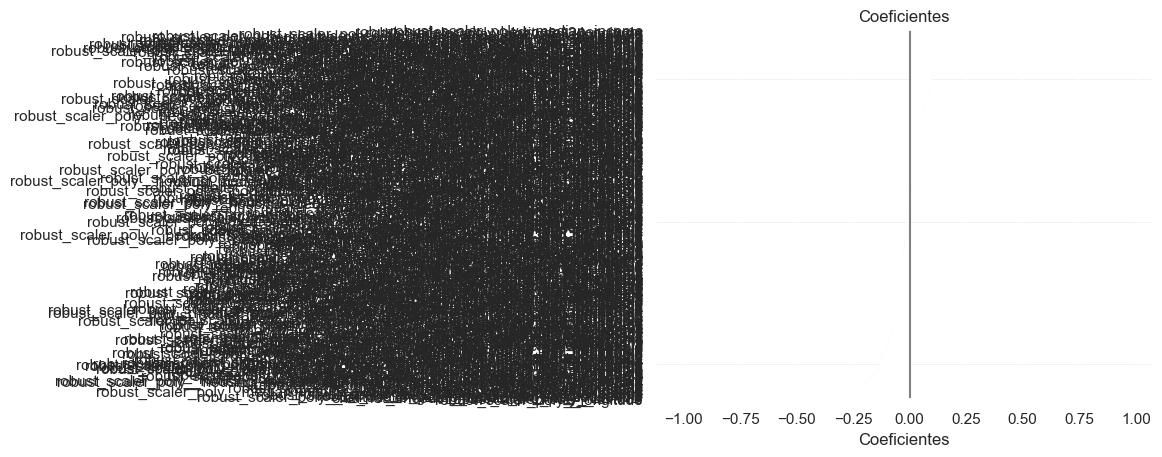

In [19]:
# criando um gráfico com os coeficientes
plot_coeficientes(coefs)

In [20]:
# verificando se existem coeficientes nulos
coefs[coefs["coeficiente"] == 0]

,coeficiente


In [21]:
# aumentando a faixa dos coeficientes, para restringir ainda mais os valores mais altos
coefs[coefs["coeficiente"].between(-0.2, 0.2) & coefs["coeficiente"] != 0]

,coeficiente
one_hot_encoder__ocean_proximity_NEAR BAY,-0.195565
robust_scaler_poly__housing_median_age population_per_household total_bedrooms,-0.195278
robust_scaler_poly__housing_median_age median_income population_per_household,-0.178961
robust_scaler_poly__households median_income^2,-0.178103
robust_scaler_poly__bedrooms_per_room rooms_per_household,-0.177130
...,...
robust_scaler_poly__total_bedrooms,0.167455
robust_scaler_poly__bedrooms_per_room rooms_per_household total_bedrooms,0.171327
robust_scaler_poly__median_income population population_per_household,0.175340
robust_scaler_poly__median_income population rooms_per_household,0.176208


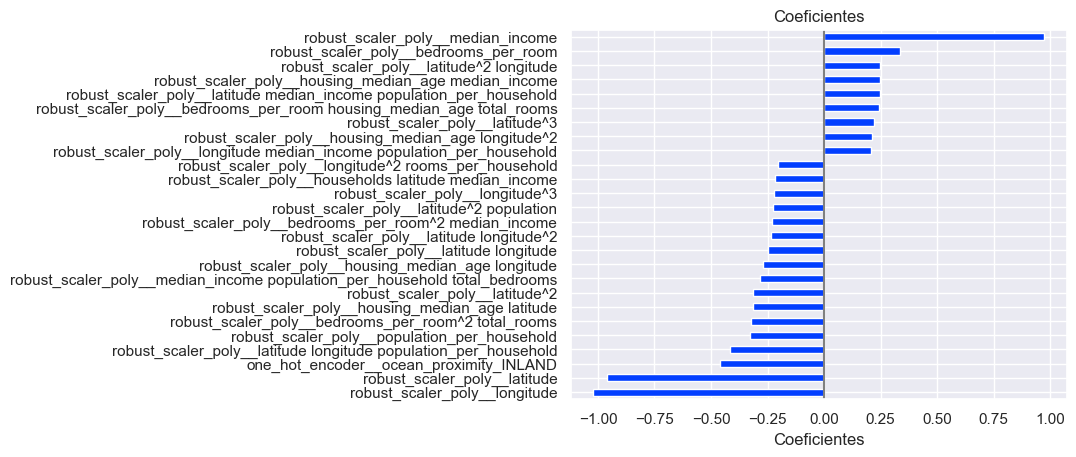

In [22]:
# criando um gráfico com os coeficientes fora da faixa estabelecida acima
# usando o operador negativo para pegar todos os coeficientes dentro da faixa
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2, 0.2)])

        Como a regularização diminui a importância de features que contribuem pouco para o target, voltamos a ver renda e localização como sendo os coeficientes principais.

In [24]:
# comparando os processamentos entre os modelos
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
   
    "LinearRegression_target":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
   
    "Ridge_grid_search":{
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

# criando um dicionário com os resultados dos modelos
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

# transformando o dicionário dos resultados em DataFrame
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003002,0.003002,-0.000081,-77516.042766,-96239.705692,0.006004
1,DummyRegressor,0.002003,0.002998,-0.000146,-75787.787194,-95217.629397,0.005001
2,DummyRegressor,0.001999,0.002,-0.001737,-76753.598961,-96253.253947,0.003999
3,DummyRegressor,0.001001,0.002003,-0.000101,-76837.804811,-95983.885799,0.003004
4,DummyRegressor,0.000996,0.001999,-0.000114,-76617.245449,-96182.764729,0.002995
5,LinearRegression,0.018,0.007001,0.682162,-39855.690996,-54254.958188,0.025001
6,LinearRegression,0.016997,0.007001,0.66999,-40272.565467,-54695.230283,0.023999
7,LinearRegression,0.018998,0.008,0.649247,-42178.05929,-56955.988706,0.026999
8,LinearRegression,0.019999,0.006999,0.669873,-40806.492497,-55146.318803,0.026999
9,LinearRegression,0.018998,0.007,0.669023,-40788.496497,-55331.35106,0.025998


In [25]:
# agrupando por modelo e apresentando a média de cada variável, ordenando pelo RMSE
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.0018,0.0024,-0.000436,-76702.495836,-95975.447913,0.0042
LinearRegression,0.018599,0.0072,0.668059,-40780.26095,-55276.769408,0.025799
LinearRegression_target,0.023599,0.0072,0.678379,-38678.789239,-54406.659332,0.030798
Ridge_grid_search,0.099593,0.0144,0.723188,-35345.012689,-50466.735188,0.113994


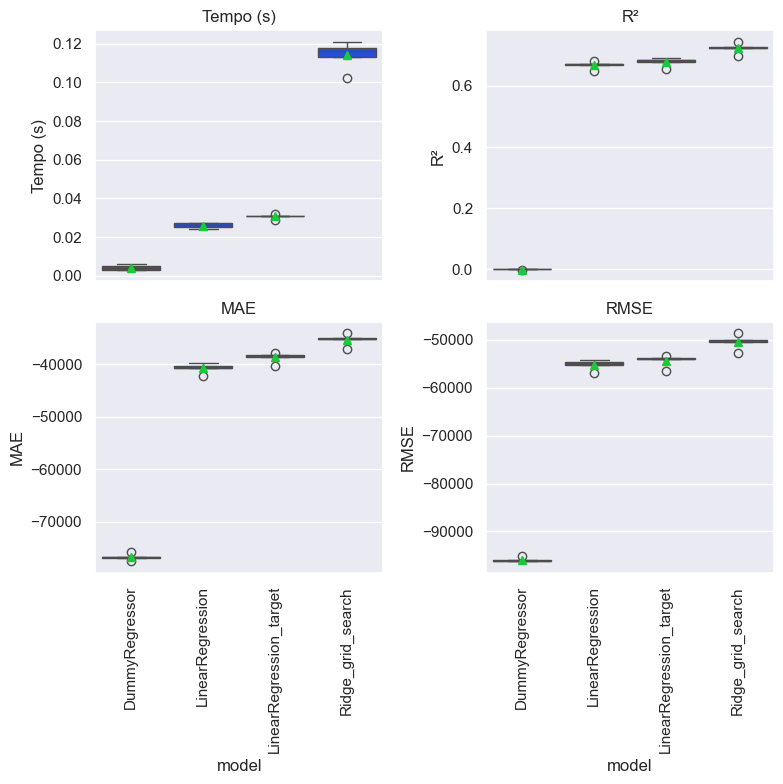

In [26]:
# criando um gráfico com a comparação dos modelos
plot_comparar_metricas_modelos(df_resultados)

        Levando em consideração a regularização Ridge, nosso modelo teve uma melhora significativa nas métricas, mesmo levando um tempo maior que os demais modelos, agora o Ridge com grid search levou na asa de 0.1 segundo. O ElasticNet levou mais de 2 segundos para treinar o modelo, além de com Ridge o tempo de treinamento ser melhor, ainda tivemos uma melhora das métricas em relação a comparação feita no notebook anterior (04-jv-modelos_parte_4).

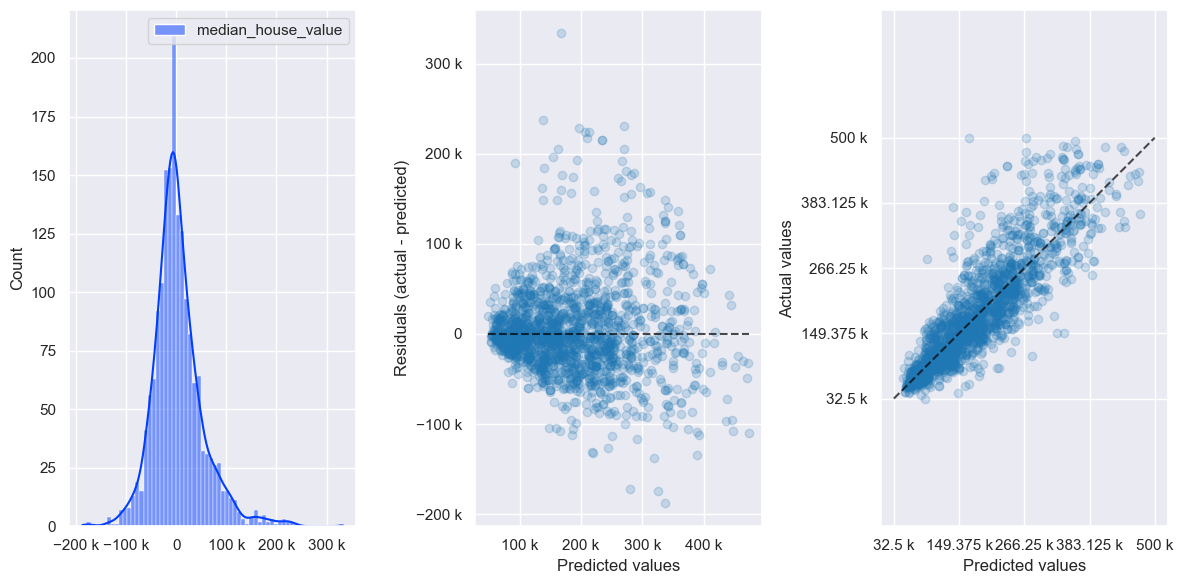

In [28]:
# verificando os resíduos
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

        Nosso modelo continua errando para menos, com valores até 300.000, mesmo assim a maior concentração de pontos está próximo de zero, mas, aparentemente, o modelo começou a errar menos já que a concentração de pontos altos parece ter diminuído.

Persistência de modelo é o processo de salvar um modelo treinado de machine learning em um arquivo ou banco de dados, para que ele possa ser reutilizado posteriormente — sem precisar ser retreinado.

https://scikit-learn.org/stable/model_persistence.html

In [31]:
# salvando o modelo treinado em um arquivo
dump(
    grid_search.best_estimator_,
    MODELO_FINAL
)

['C:\\Users\\barbo\\Downloads\\10 - Aprendizado de máquina\\regressao\\projeto_regressao\\modelos\\ridge_polyfeat_target_quantile.joblib']

        O modelo de machine learning foi salvo no caminho acima, o ideal é conferir se o salvamento está finalizado. Com o salvamento do modelo, não é necessário interagir com ele via notebook do jupyter, agora ele pode ser carregado em um outro ambiente. Para que a persistência de modelo seja bem utilizado, é necessário criar uma interface para interagir com esse modelo, possibilitando que qualquer pessoa inclua dados e faça previsões por meio dessa interface.

Devido ao problema que o Anaconda Navigator apresenta no windows, que não altera o ambiente virtual, mesmo dando o comando para sua troca no terminal, o Anaconda Navigator sempre inicializa no ambiente virtual padrão, ele não é o adequado, já que as versões de bibliotecas específicas de um projeto ficam salvam no ambiente virtual. Com isso, podemos resolver essa situação da seguinte maneria, ativando o ambiente virtual específico pelo terminal do Anaconda Powershell Prompt, realizar a instalação do JupyterLab dentro do ambiente virtual de acordo com [doc JupyterLab](https://jupyterlab.readthedocs.io/en/latest/getting_started/installation.html), após essa instalação é possível iniciar o Jupyter Lab no ambiente virtual selecionado pelo comando `jupyter lab` no terminal.